In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# make the original data
series = np.sin((0.1*np.arange(400))**2)

This is a time series of the form:

x(t) = sin(wt^2)

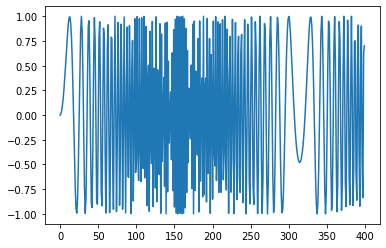

In [3]:
# Plot it
plt.plot(series)
plt.show()

In [4]:
# Build the dataset using T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T) # make it N x T
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (390, 10) Y.shape (390, 1)


In [5]:
# Try autoregressive linear model
model_LIN = nn.Linear(T, 1)

In [6]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_LIN.parameters(), lr=0.1)

In [7]:
# Make inputs and targets
X_train_LIN = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train_LIN = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test_LIN = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test_LIN = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [8]:
#Training
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):
  
  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()

    if (it+1) % 5 == 0:
      print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {loss.item():.4f}')

  return train_losses, test_losses

In [9]:
train_losses_LIN, test_losses_LIN = full_gd(model_LIN,
                                    criterion,
                                    optimizer,
                                    X_train_LIN,
                                    y_train_LIN,
                                    X_test_LIN,
                                    y_test_LIN)

Epoch 5/200, Train Loss: 0.5059, Test Loss: 0.5059
Epoch 10/200, Train Loss: 0.5076, Test Loss: 0.5076
Epoch 15/200, Train Loss: 0.4992, Test Loss: 0.4992
Epoch 20/200, Train Loss: 0.4896, Test Loss: 0.4896
Epoch 25/200, Train Loss: 0.4898, Test Loss: 0.4898
Epoch 30/200, Train Loss: 0.4848, Test Loss: 0.4848
Epoch 35/200, Train Loss: 0.4865, Test Loss: 0.4865
Epoch 40/200, Train Loss: 0.4835, Test Loss: 0.4835
Epoch 45/200, Train Loss: 0.4844, Test Loss: 0.4844
Epoch 50/200, Train Loss: 0.4836, Test Loss: 0.4836
Epoch 55/200, Train Loss: 0.4835, Test Loss: 0.4835
Epoch 60/200, Train Loss: 0.4836, Test Loss: 0.4836
Epoch 65/200, Train Loss: 0.4834, Test Loss: 0.4834
Epoch 70/200, Train Loss: 0.4834, Test Loss: 0.4834
Epoch 75/200, Train Loss: 0.4834, Test Loss: 0.4834
Epoch 80/200, Train Loss: 0.4833, Test Loss: 0.4833
Epoch 85/200, Train Loss: 0.4833, Test Loss: 0.4833
Epoch 90/200, Train Loss: 0.4833, Test Loss: 0.4833
Epoch 95/200, Train Loss: 0.4833, Test Loss: 0.4833
Epoch 100/200

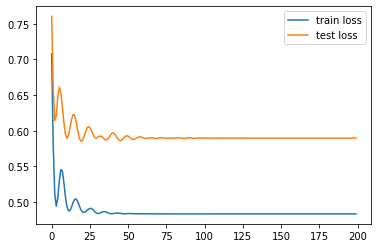

In [10]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses_LIN, label='train loss')
plt.plot(test_losses_LIN, label='test loss')
plt.legend()
plt.show()

Test loss doesn't really decrease while train lost does, suggesting that the model is overfitting to the training data and not really understanding the underlying phenomenon. 

In [11]:
# One-step forecast using true targets
# Note: even the one-step forecast fails badly
validation_target = Y[-N//2:]
with torch.no_grad():
  validation_predictions_LIN1 = model_LIN(X_test_LIN).numpy()

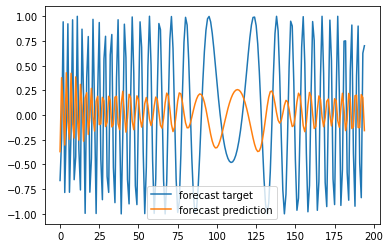

In [12]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions_LIN1, label='forecast prediction')
plt.legend()

In [13]:
# Multi-step forecast
validation_predictions_LIN2 = []

# last train input
# last_x = torch.from_numpy(X[-N//2]) # 1-D array of length T
last_x = torch.from_numpy(X[-N//2].astype(np.float32))

while len(validation_predictions_LIN2) < len(validation_target):
  input_ = last_x.reshape(1, -1)
  p = model_LIN(input_)
  # [0,0] # 1x1 array -> scalar

  # update the predictions list
  validation_predictions_LIN2.append(p[0,0].item())

  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

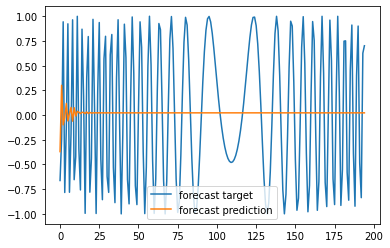

In [14]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions_LIN2, label='forecast prediction')
plt.legend()

This is (as the experts say) *hot garbaggio* so clearly this is not an appropriate technique for the problem. Now let's see how things improve when a simpleRNN is used instead. 

In [15]:
# Build the dataset using T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # make it N x T x D
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (390, 10, 1) Y.shape (390, 1)


In [16]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [17]:
### Define simple RNN
class SimpleRNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(SimpleRNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    # note : batch_first=True
    # applies the convention that the data will be of shape:
    # (num_samples, sequence_length, num_features)
    # rather than:
    # (sequence_length, num_samples, num_features)
    self.rnn = nn.RNN(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        nonlinearity='relu',
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K) # final dense layer of size M x K

  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get RNN unit output
    # out is of size (N, T, M)
    # 2nd return value is hidden states at each hidden layer
    # which are not needed right now
    out, _ = self.rnn(X, h0)

    # Only interested in h(T) at the final time step
    # N x M -> N x K
    out = self.fc(out[:, -1, :])
    return out


In [18]:
# Instantiate the model
model_RNN = SimpleRNN(n_inputs=1, n_hidden=5, n_rnnlayers=1, n_outputs=1)
model_RNN.to(device)

SimpleRNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_RNN.parameters(), lr=0.05)

In [20]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [21]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [22]:
train_losses_RNN, test_losses_RNN = full_gd(model_RNN,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 0.5109, Test Loss: 0.5109
Epoch 10/200, Train Loss: 0.4947, Test Loss: 0.4947
Epoch 15/200, Train Loss: 0.4902, Test Loss: 0.4902
Epoch 20/200, Train Loss: 0.4900, Test Loss: 0.4900
Epoch 25/200, Train Loss: 0.4883, Test Loss: 0.4883
Epoch 30/200, Train Loss: 0.4854, Test Loss: 0.4854
Epoch 35/200, Train Loss: 0.4837, Test Loss: 0.4837
Epoch 40/200, Train Loss: 0.4806, Test Loss: 0.4806
Epoch 45/200, Train Loss: 0.4620, Test Loss: 0.4620
Epoch 50/200, Train Loss: 0.4326, Test Loss: 0.4326
Epoch 55/200, Train Loss: 0.3908, Test Loss: 0.3908
Epoch 60/200, Train Loss: 0.2929, Test Loss: 0.2929
Epoch 65/200, Train Loss: 0.2519, Test Loss: 0.2519
Epoch 70/200, Train Loss: 0.2310, Test Loss: 0.2310
Epoch 75/200, Train Loss: 0.2122, Test Loss: 0.2122
Epoch 80/200, Train Loss: 0.2101, Test Loss: 0.2101
Epoch 85/200, Train Loss: 0.2062, Test Loss: 0.2062
Epoch 90/200, Train Loss: 0.2024, Test Loss: 0.2024
Epoch 95/200, Train Loss: 0.2008, Test Loss: 0.2008
Epoch 100/200

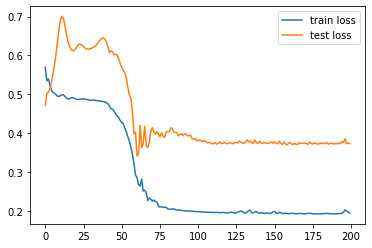

In [23]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses_RNN, label='train loss')
plt.plot(test_losses_RNN, label='test loss')
plt.legend()
plt.show()

In [24]:
# One-step forecast using true targets
# Note: even the one-step forecast fails badly
validation_predictions_RNN1 = []

# index of first validation input
i = 0

while len(validation_predictions_RNN1) < len(validation_target):
  input_ = X_test[i].reshape(1, T, 1)
  p = model_RNN(input_)[0,0].item() # 1x1 array -> scalar
  i += 1

  # update the predictions list
  validation_predictions_RNN1.append(p)

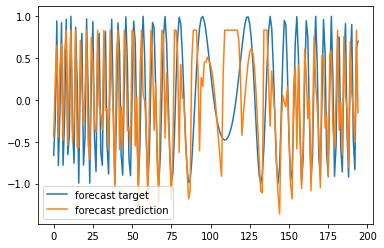

In [25]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions_RNN1, label='forecast prediction')
plt.legend()

In [26]:
# Multi-step forecast
validation_predictions_RNN2 = []

# last train input
last_x = X_test[0].view(T)

while len(validation_predictions_RNN2) < len(validation_target):
  input_ = last_x.reshape(1, T, 1)
  p = model_RNN(input_)

  # update the predictions list
  validation_predictions_RNN2.append(p[0,0].item())

  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

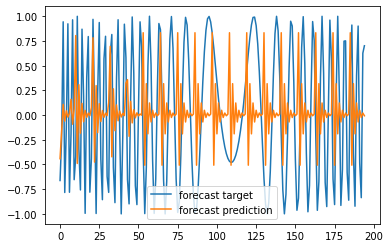

In [27]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions_RNN2, label='forecast prediction')
plt.legend()

In [28]:
### Define simple RNN
class SimpleLSTM(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(SimpleLSTM, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    # note : batch_first=True
    # applies the convention that the data will be of shape:
    # (num_samples, sequence_length, num_features)
    # rather than:
    # (sequence_length, num_samples, num_features)
    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K) # final dense layer of size M x K

  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get RNN unit output
    # out is of size (N, T, M)
    # 2nd return value is hidden states at each hidden layer
    # which are not needed right now
    out, _ = self.rnn(X, (h0, c0))

    # Only interested in h(T) at the final time step
    # N x M -> N x K
    out = self.fc(out[:, -1, :])
    return out


In [29]:
# Instantiate the model
model_LSTM = SimpleLSTM(n_inputs=1, n_hidden=10, n_rnnlayers=1, n_outputs=1)
model_LSTM.to(device)

SimpleLSTM(
  (rnn): LSTM(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [30]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_LSTM.parameters(), lr=0.05)

In [31]:
train_losses_LSTM, test_losses_LSTM = full_gd(model_LSTM,
                                              criterion,
                                              optimizer,
                                              X_train,
                                              y_train,
                                              X_test,
                                              y_test)

Epoch 5/200, Train Loss: 0.5174, Test Loss: 0.5174
Epoch 10/200, Train Loss: 0.4990, Test Loss: 0.4990
Epoch 15/200, Train Loss: 0.4841, Test Loss: 0.4841
Epoch 20/200, Train Loss: 0.4385, Test Loss: 0.4385
Epoch 25/200, Train Loss: 0.4010, Test Loss: 0.4010
Epoch 30/200, Train Loss: 0.3269, Test Loss: 0.3269
Epoch 35/200, Train Loss: 0.1925, Test Loss: 0.1925
Epoch 40/200, Train Loss: 0.0517, Test Loss: 0.0517
Epoch 45/200, Train Loss: 0.0444, Test Loss: 0.0444
Epoch 50/200, Train Loss: 0.0300, Test Loss: 0.0300
Epoch 55/200, Train Loss: 0.0220, Test Loss: 0.0220
Epoch 60/200, Train Loss: 0.0135, Test Loss: 0.0135
Epoch 65/200, Train Loss: 0.0103, Test Loss: 0.0103
Epoch 70/200, Train Loss: 0.0075, Test Loss: 0.0075
Epoch 75/200, Train Loss: 0.0055, Test Loss: 0.0055
Epoch 80/200, Train Loss: 0.0040, Test Loss: 0.0040
Epoch 85/200, Train Loss: 0.0034, Test Loss: 0.0034
Epoch 90/200, Train Loss: 0.0029, Test Loss: 0.0029
Epoch 95/200, Train Loss: 0.0026, Test Loss: 0.0026
Epoch 100/200

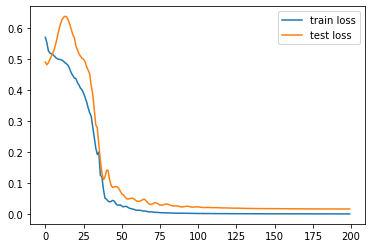

In [32]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses_LSTM, label='train loss')
plt.plot(test_losses_LSTM, label='test loss')
plt.legend()
plt.show()

In [33]:
# One-step forecast using true targets
# Note: even the one-step forecast fails badly
validation_predictions_LSTM1 = []

# index of first validation input
i = 0

while len(validation_predictions_LSTM1) < len(validation_target):
  input_ = X_test[i].reshape(1, T, 1)
  p = model_LSTM(input_)[0,0].item() # 1x1 array -> scalar
  i += 1

  # update the predictions list
  validation_predictions_LSTM1.append(p)

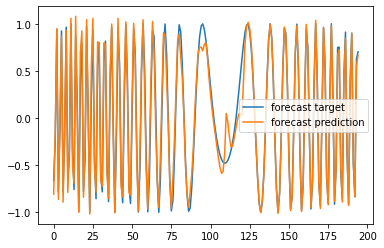

In [34]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions_LSTM1, label='forecast prediction')
plt.legend()

In [35]:
# Multi-step forecast
validation_predictions_LSTM2 = []

# last train input
last_x = X_test[0].view(T)

while len(validation_predictions_LSTM2) < len(validation_target):
  input_ = last_x.reshape(1, T, 1)
  p = model_LSTM(input_)

  # update the predictions list
  validation_predictions_LSTM2.append(p[0,0].item())

  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

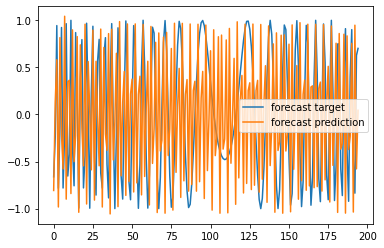

In [36]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions_LSTM2, label='forecast prediction')
plt.legend()

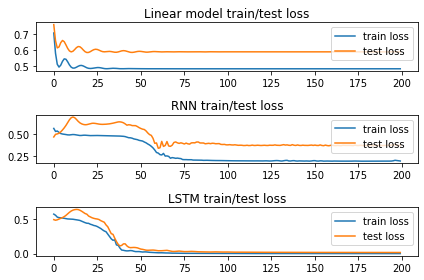

In [40]:
plt.subplot(3, 1, 1)
plt.plot(train_losses_LIN, label='train loss')
plt.plot(test_losses_LIN, label='test loss')
plt.legend()
plt.title('Linear model train/test loss')

plt.subplot(3, 1, 2)
plt.plot(train_losses_RNN, label='train loss')
plt.plot(test_losses_RNN, label='test loss')
plt.legend()
plt.title('RNN train/test loss')

plt.subplot(3, 1, 3)
plt.plot(train_losses_LSTM, label='train loss')
plt.plot(test_losses_LSTM, label='test loss')
plt.legend()
plt.title('LSTM train/test loss')

plt.tight_layout()
plt.show()

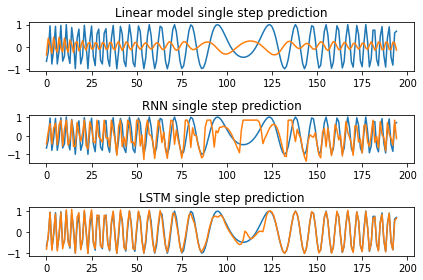

In [37]:
plt.subplot(3, 1, 1)
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions_LIN1, label='forecast prediction')
plt.title('Linear model single step prediction')

plt.subplot(3, 1, 2)
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions_RNN1, label='forecast prediction')
plt.title('RNN single step prediction')

plt.subplot(3, 1, 3)
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions_LSTM1, label='forecast prediction')
plt.title('LSTM single step prediction')

plt.tight_layout()
plt.show()

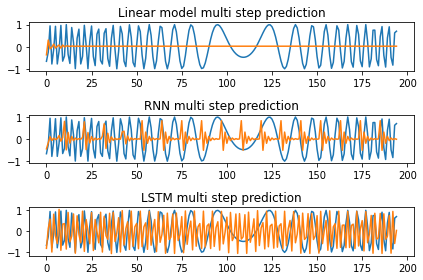

In [38]:
plt.subplot(3, 1, 1)
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions_LIN2, label='forecast prediction')
plt.title('Linear model multi step prediction')

plt.subplot(3, 1, 2)
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions_RNN2, label='forecast prediction')
plt.title('RNN multi step prediction')

plt.subplot(3, 1, 3)
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions_LSTM2, label='forecast prediction')
plt.title('LSTM multi step prediction')

plt.tight_layout()
plt.show()

LSTMs are better than RNNs at finding long term dependencies, but this doesn't necessarily hold true for arbitrarily long data. There is a point where even LSTMs start to forget. There is no long term dependency for this problem, so an LSTM holds no particular advantage over RNNs. 